In [1]:
import ProtobufTypes_pb2 
import pandas as pd
import sys
from google.protobuf.json_format import MessageToDict
import collections
import numpy as np
import glob
import seaborn as sns
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
import pprint
from IPython.display import display
from datetime import date
# rcParams.keys()

In [2]:
PROCESSED_DATA_PATH = '../ProcessedData'
PLOT_PATH = f'./PLOTS-{date.today().strftime("%b-%d-%Y")}/fixations_grasps/'

os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

sns.set(context = "talk", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':15, 'font.sans-serif':'DejaVu Sans'})

In [3]:
objs_dict = {'Other':0, 'Cube_Blue': 1, 'Cube_Green':2, 'Cube_Red':3, 'Cube_Yellow':4, 'Cylinder_Blue':5,
             'Cylinder_Green':6, 'Cylinder_Red':7, 'Cylinder_Yellow':8, 'Sphere_Blue':9, 'Sphere_Green':10,
             'Sphere_Red':11, 'Sphere_Yellow':12, 'Tetraeder_Blue':13, 'Tetraeder_Green':14,
             'Tetraeder_Red':15, 'Tetraeder_Yellow':16}

In [23]:
samples_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/03_ET_samples_withGraspOnset.csv', index_col=False)

In [6]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10594907 entries, 0 to 10594906
Data columns (total 95 columns):
timestamp                           float64
Unnamed: 0                          int64
leftEye_position_x                  float64
leftEye_position_y                  float64
leftEye_position_z                  float64
leftEye_direction_x                 float64
leftEye_direction_y                 float64
leftEye_direction_z                 float64
leftEye_raycastHitObject            object
leftEye_raycastHitLocation_x        float64
leftEye_raycastHitLocation_y        float64
leftEye_raycastHitLocation_z        float64
rightEye_position_x                 float64
rightEye_position_y                 float64
rightEye_position_z                 float64
rightEye_direction_x                float64
rightEye_direction_y                float64
rightEye_direction_z                float64
rightEye_raycastHitObject           object
rightEye_raycastHitLocation_x       float64
rightEye_

In [24]:
def replace_objs(s):
    valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 'Cylinder_Blue', 'Cylinder_Green',
                  'Cylinder_Red','Cylinder_Yellow', 'Sphere_Blue', 'Sphere_Green', 'Sphere_Red',
                  'Sphere_Yellow', 'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']
    if s in valid_objs:
        return s
    else:
        return 'Other'

# samples_df.handData_graspedObject = samples_df.handData_graspedObject.apply(replace_objs)
samples_df.combinedEye_raycastHitObject = samples_df.combinedEye_raycastHitObject.apply(replace_objs)

In [27]:
(samples_df
 .query('timestamp == grasp_onset and grasp_duration !=0 ')
#  .groupby('trialID')
 .grasp_onset
 .count()
)

20603

In [29]:
samples_df.query('grasp_duration!=0').grasp_duration.describe()

count    3.466959e+06
mean     3.064418e+00
std      3.467341e+00
min      1.124573e-02
25%      1.450138e+00
50%      1.999498e+00
75%      3.097557e+00
max      3.262085e+01
Name: grasp_duration, dtype: float64

In [25]:
samples_df['grasp_onset_bool'] = False
idx = samples_df.query('timestamp == grasp_onset and grasp_duration>1').index
samples_df.loc[idx, 'grasp_onset_bool'] = True
# samples_df.loc[~idx, 'handData_graspedObject'] = np.nan

In [26]:
samples_df['fix_onset_bool'] = False
idx = samples_df.query('timestamp == fix_onset and corrected_fix_duration !=0 and isFixV==1').index
samples_df.loc[idx, 'fix_onset_bool'] = True

In [32]:
samples_df.to_csv(f'{PROCESSED_DATA_PATH}/04_ET_samples_withGraspFixOnset.csv', index=False)

In [ ]:
samples_df.query('isFixV==True and corrected_fix_duration!=0')

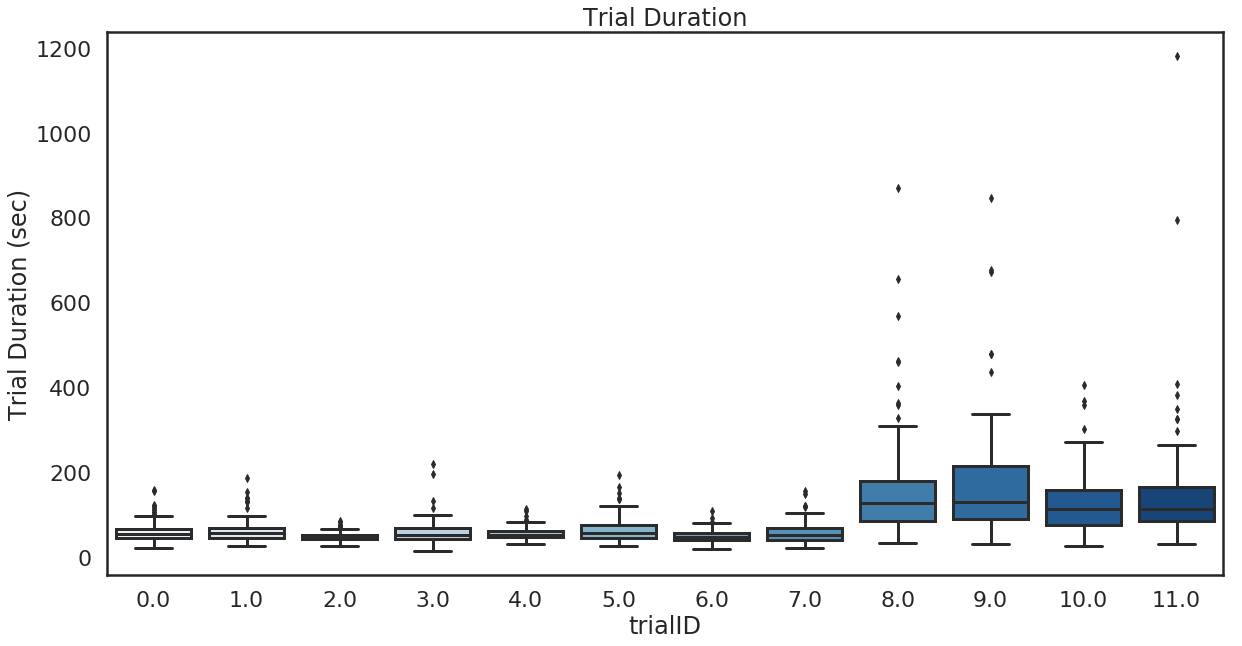

In [79]:
tmpdf = (
    samples_df
    .set_index('timestamp')
    .groupby(['subjectID','subjectfileName','trialID', 'trialNum'])
    .apply(lambda x: x.index[-1] - x.index[0])
    .rename('TrialDuration')
    .reset_index()
)
# display(tmpdf)
sns.set(context = "poster", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
_, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=tmpdf, x='trialID', y='TrialDuration', palette='Blues' )
# ax.set_ylim(60,120)
# plt.xticks(rotation=90, fontsize=15)
plt.ylabel('Trial Duration (sec)')
plt.title('Trial Duration')
plt.savefig(PLOT_PATH+'/TrialDuration.png', quality=90)

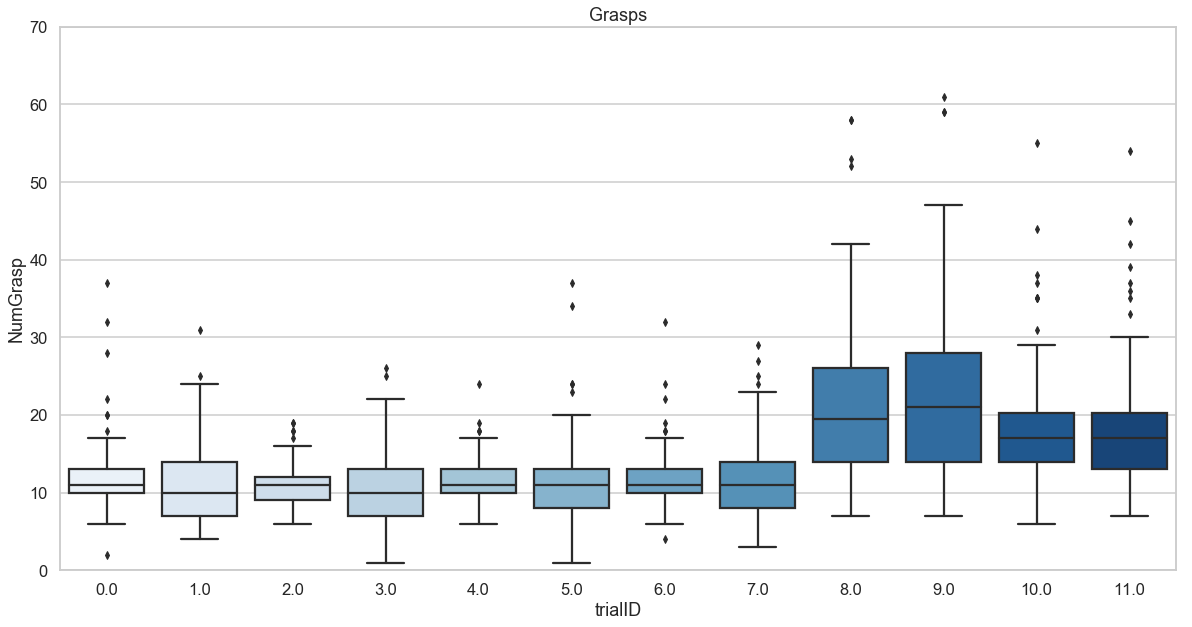

In [30]:
tmpdf = (samples_df
 .query('timestamp == grasp_onset and grasp_duration !=0 ')
 .groupby(['subjectID','subjectfileName','trialNum','trialID',], as_index=False)
 .grasp_onset
 .count()
 .rename(columns = {'grasp_onset':'NumGrasp'})
)

_, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=tmpdf, x='trialID', y='NumGrasp', palette='Blues',)
ax.set_ylim(0,70)
# plt.xticks(rotation=90, fontsize=15)
plt.title('Grasps')
plt.savefig(PLOT_PATH+'/grasps.png', quality=90)

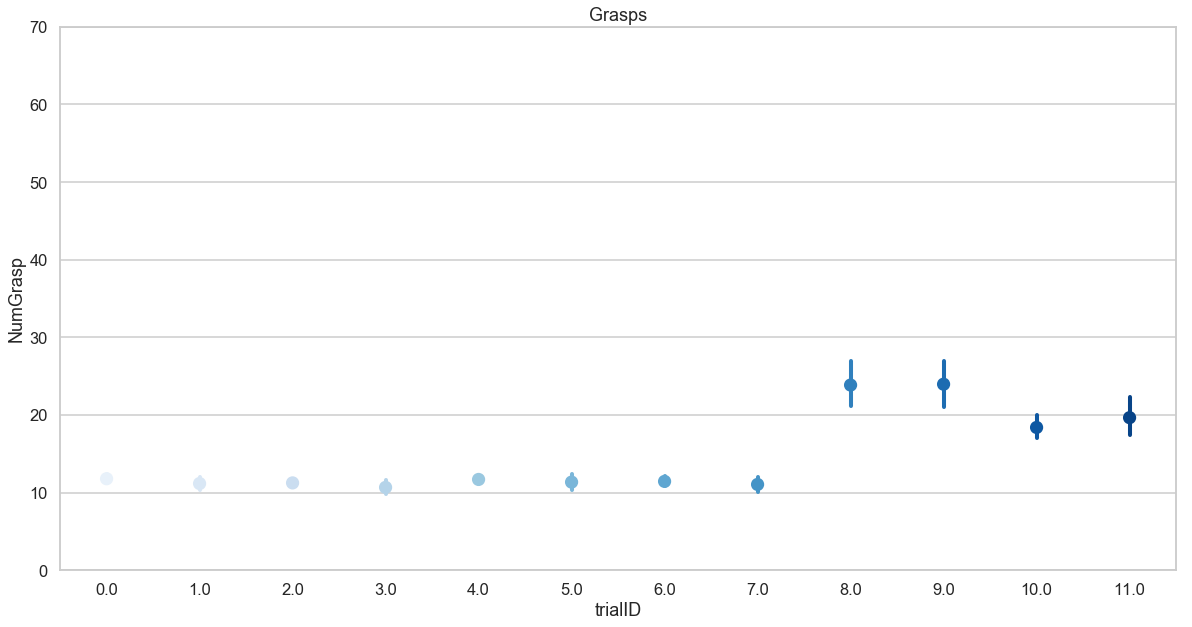

In [31]:
tmpdf = (samples_df
 .query('timestamp == grasp_onset and grasp_duration !=0 ')
 .groupby(['subjectID','subjectfileName','trialNum','trialID',], as_index=False)
 .grasp_onset
 .count()
 .rename(columns = {'grasp_onset':'NumGrasp'})
)

_, ax = plt.subplots(1,1,figsize=(20,10))
sns.pointplot(data=tmpdf, x='trialID', y='NumGrasp', palette='Blues',)
ax.set_ylim(0,70)
# plt.xticks(rotation=90, fontsize=15)
plt.title('Grasps')
plt.savefig(PLOT_PATH+'/grasps.png', quality=90)

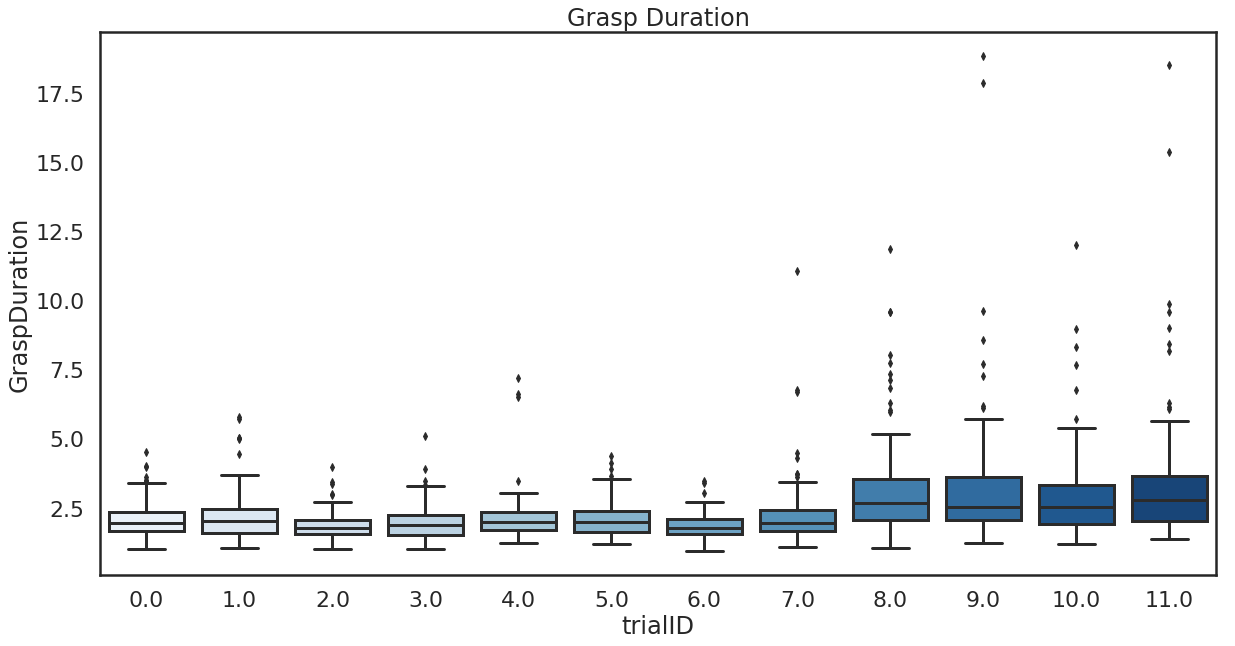

In [59]:
tmpdf = (samples_df
 .query('grasp_duration !=0 ')
 .groupby(['subjectID','subjectfileName','trialID','trialNum',], as_index=False)
 .grasp_duration
 .mean()
 .rename(columns = {'grasp_duration':'GraspDuration'})
)

_, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=tmpdf, x='trialID', y='GraspDuration', palette='Blues',)
# ax.set_ylim(0,70)
# plt.xticks(rotation=90, fontsize=15)
plt.title('Grasp Duration')
plt.savefig(PLOT_PATH+'/graspDuration.png', quality=90)

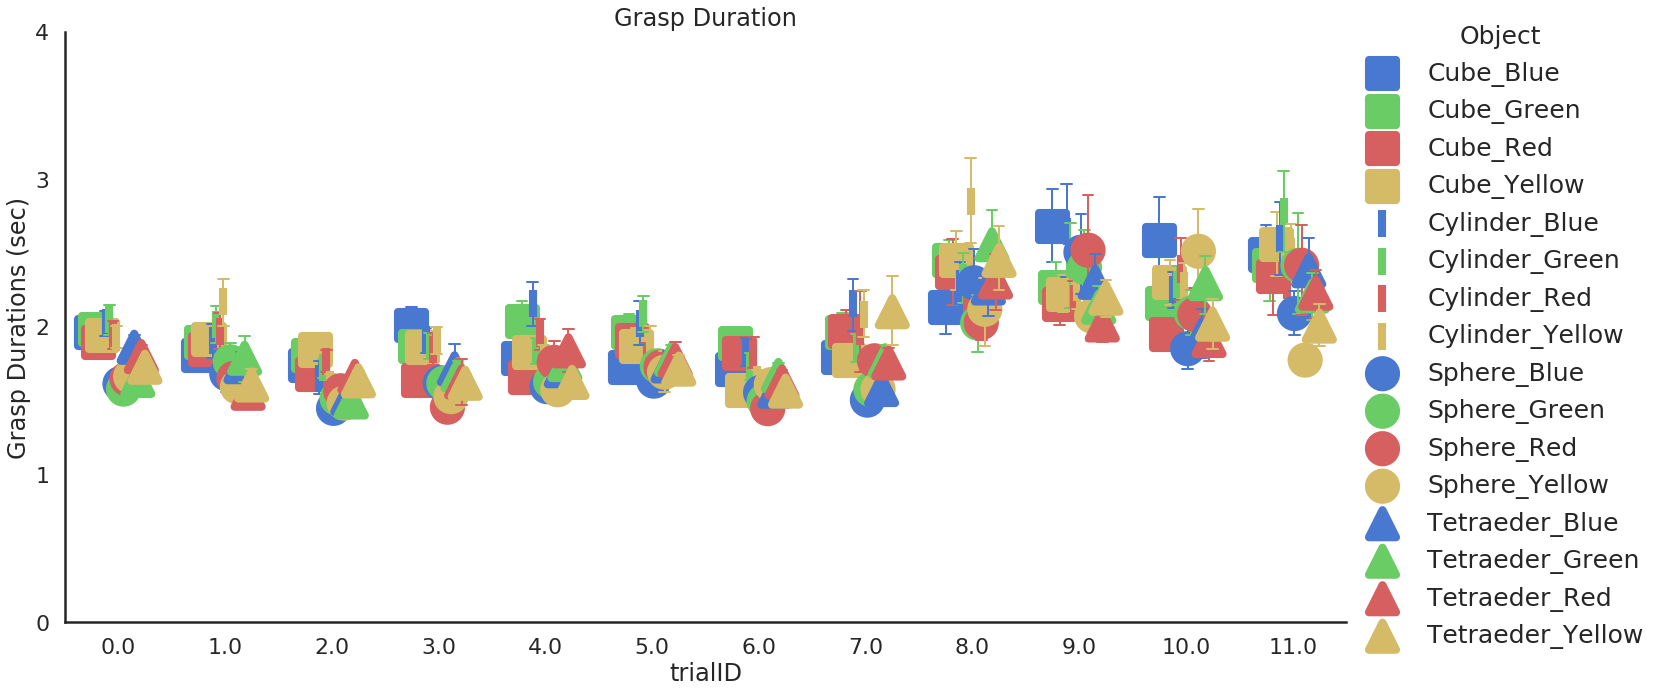

In [54]:
objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 'Cylinder_Blue', 'Cylinder_Green',
        'Cylinder_Red','Cylinder_Yellow', 'Sphere_Blue', 'Sphere_Green', 'Sphere_Red',
        'Sphere_Yellow', 'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']
markers = ['s','s','s','s', '|','|','|','|', 'o','o','o','o', '^','^','^','^']
colors = ['b', 'g', 'r', 'y']
tmpdf = (samples_df
 .query('grasp_duration !=0 ')
 .groupby(['subjectID','subjectfileName','trialID','trialNum','handData_graspedObject'], as_index=False)
 .grasp_duration
 .mean()
 .rename(columns = {'grasp_duration':'GraspDuration'})
)
sns.set(context = "poster", style="white", palette="muted", font_scale=1,\
        rc={'figure.figsize':(22,10), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
g = (
    sns.catplot(
        x='trialID', y='GraspDuration', data=tmpdf, hue ='handData_graspedObject',
        hue_order=objs, markers=markers, palette=colors,
                  kind='point',scale = 2,
                  errwidth=2, capsize=0.1,
                  ci=68,, join=False,
        height = 10, aspect = 2, legend_out=False, legend=False
        
    )
)
g.set(ylabel='Grasp Durations (sec)', yticks=[0,1,2,3, 4])
plt.legend(title = 'Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.05), fontsize=25)
plt.title('Grasp Duration')
plt.savefig(PLOT_PATH+'/graspDuration_perObject.png', transparent=True, bbox_inches='tight', quality=90)

In [35]:
objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 'Cylinder_Blue', 'Cylinder_Green',
                  'Cylinder_Red','Cylinder_Yellow', 'Sphere_Blue', 'Sphere_Green', 'Sphere_Red',
                  'Sphere_Yellow', 'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']
markers = ['s','s','s','s', '|','|','|','|', 'o','o','o','o', '^','^','^','^']
colors = ['b', 'g', 'r', 'y']
tmpdf = (samples_df
 .query('timestamp == grasp_onset and grasp_duration !=0 ')
 .groupby(['subjectID','trialID', 'subjectfileName','trialNum',], as_index=False)
 .grasp_onset
 .count()
 .rename(columns = {'grasp_onset':'NumGrasp'})
)
display(tmpdf.groupby('trialID').NumGrasp.mean())
sns.set(context = "poster", style="white", palette="muted", font_scale=1,\
        rc={'figure.figsize':(22,10), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
g = (
    sns.catplot(
        x='trialID', y='NumGrasp', data=tmpdf, hue ='handData_graspedObject', 
        hue_order= objs, markers=markers,palette=colors,
        kind='point',scale = 2,
        errwidth=2, capsize=0.1,
        ci=68, join=False,
        height = 10, aspect = 2.2, legend_out=False, legend=False
        
    )
)
g.set(ylabel='Number of Grasps', ylim=(0,5), yticks=[0,1,2,3, 4, 5])
plt.legend(title = 'Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.05), fontsize=25)
plt.title('Grasps per trial')
plt.savefig(PLOT_PATH+'/grasps_pertrial.png', transparent=True, bbox_inches='tight', quality=90)

trialID
0.0     11.790419
1.0     11.173913
2.0     11.254386
3.0     10.675439
4.0     11.698276
5.0     11.357798
6.0     11.448276
7.0     11.056075
8.0     23.855932
9.0     23.962963
10.0    18.392857
11.0    19.655172
Name: NumGrasp, dtype: float64

ValueError: Could not interpret input 'handData_graspedObject'

In [ ]:
tmpdf.NumGrasp.describe()

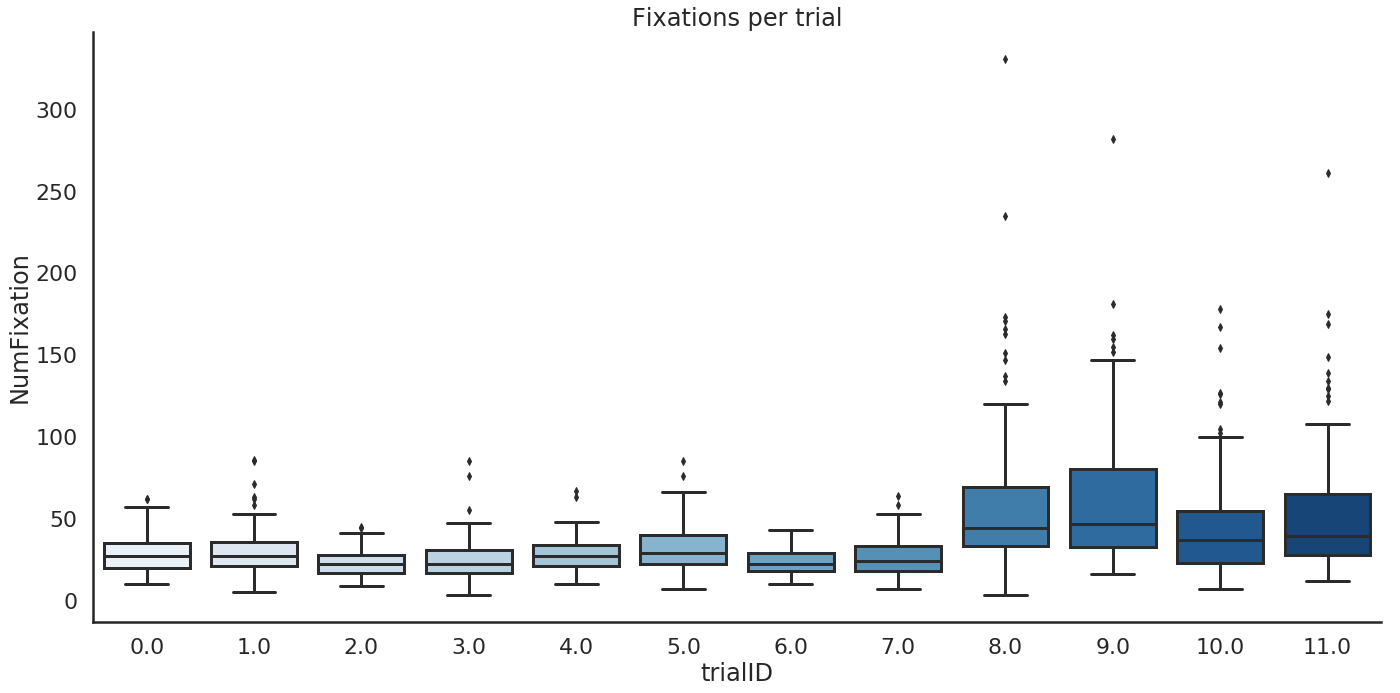

In [60]:
tmpdf = (samples_df
 .drop_duplicates(subset=['fix_duration'], keep='first')
 .query('isFixV == 1 and corrected_fix_duration !=0 and combinedEye_raycastHitObject != "Other" and isOutlierFix==0')
 .groupby(['subjectID','trialID','subjectfileName','trialNum',], as_index=False)
 .timestamp
 .count()
 .rename(columns = {'timestamp':'NumFixation'})
)

# _, ax = plt.subplots(1,1,figsize=(12,9))
# sns.pointplot(data=tmpdf, x='trialID', y='NumSamples', hue='combinedEye_raycastHitObject',palette='deep',
#               errwidth=2, capsize=0.1, saturation=0.5, ci=68, join=False, dodge=True, legend_out=True)
sns.set(context = "poster", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(20,10), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
g = (
    sns.catplot(
        x='trialID', y='NumFixation', data=tmpdf, 
                  kind='box',palette='Blues',
#                   errwidth=2, capsize=0.1,
#                   ci=68,  dodge=0.5, join=False,
        height = 10, aspect = 2, legend_out=False, legend=False
        
    )
)
# g.set(ylabel='Relative Frequency', xlabel='Alignment Type', ylim = (0,1))
# plt.legend(title = 'Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.05), fontsize=25)
plt.title('Fixations per trial')
plt.savefig(PLOT_PATH+'/fixationspertrial.png', transparent=True, bbox_inches='tight', quality=90)

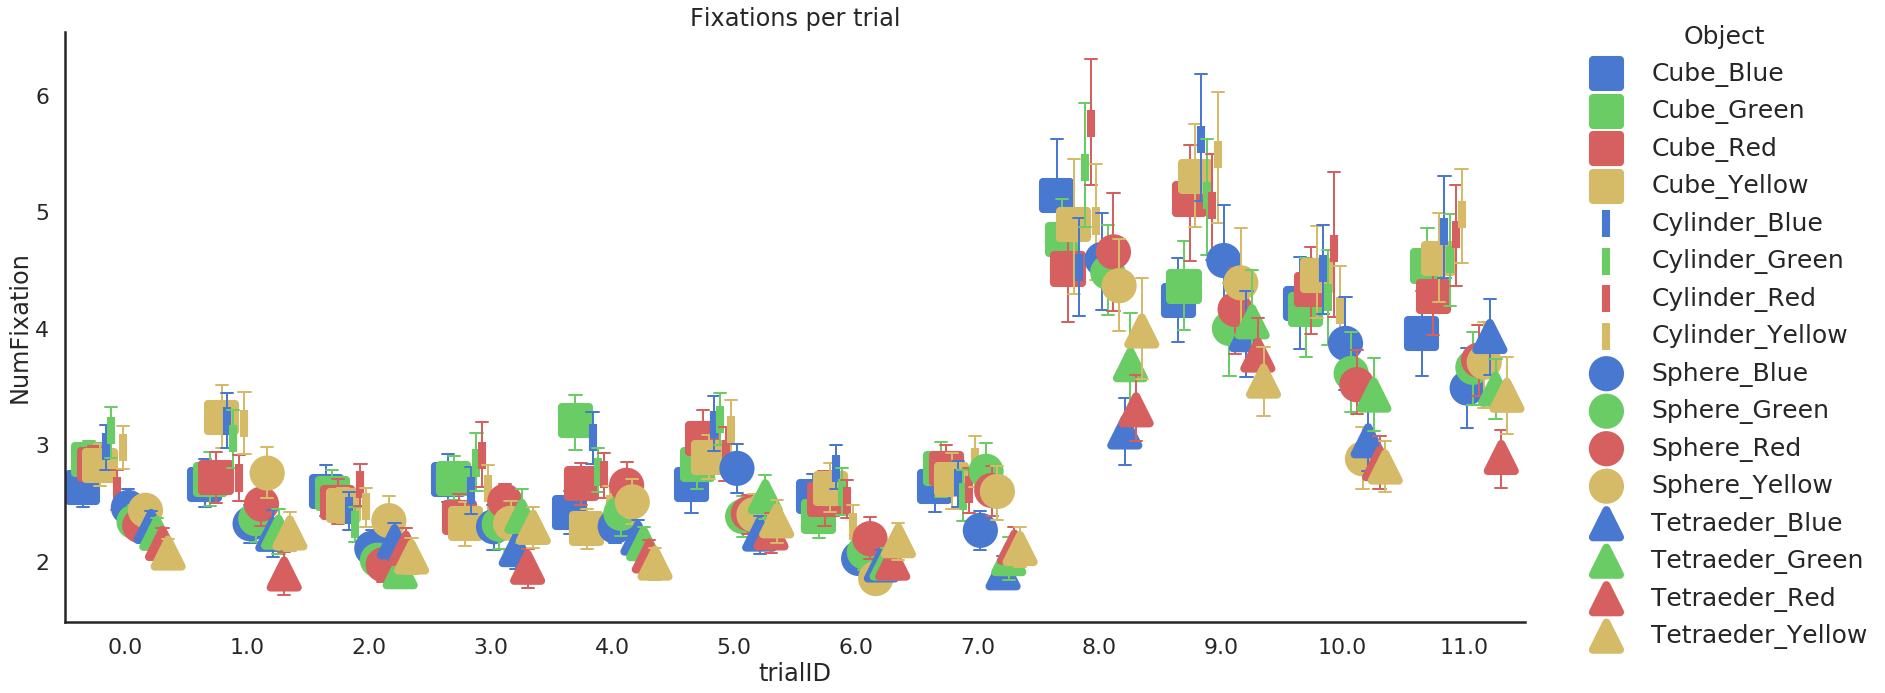

In [56]:
objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 'Cylinder_Blue', 'Cylinder_Green',
                  'Cylinder_Red','Cylinder_Yellow', 'Sphere_Blue', 'Sphere_Green', 'Sphere_Red',
                  'Sphere_Yellow', 'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']
markers = ['s','s','s','s', '|','|','|','|', 'o','o','o','o', '^','^','^','^']
colors = ['b', 'g', 'r', 'y']
tmpdf = (samples_df
 .drop_duplicates(subset=['corrected_fix_duration'], keep='first')
 .query('isFixV == 1 and corrected_fix_duration !=0 and combinedEye_raycastHitObject != "Other"')
 .groupby(['subjectID','trialID','subjectfileName','trialNum','combinedEye_raycastHitObject'], as_index=False)
 .timestamp
 .count()
 .rename(columns = {'timestamp':'NumFixation'})
)

# _, ax = plt.subplots(1,1,figsize=(12,9))
# sns.pointplot(data=tmpdf, x='trialID', y='NumSamples', hue='combinedEye_raycastHitObject',palette='deep',
#               errwidth=2, capsize=0.1, saturation=0.5, ci=68, join=False, dodge=True, legend_out=True)
sns.set(context = "poster", style="white", palette="muted", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
g = (
    sns.catplot(
        x='trialID', y='NumFixation', data=tmpdf, hue ='combinedEye_raycastHitObject', 
        hue_order=objs, markers=markers, palette=colors,
                  kind='point',scale = 2,
                  errwidth=2, capsize=0.1,
                  ci=68,  dodge=0.7, join=False,
        height = 10, aspect = 2.2, legend_out=False, legend=False
        
    )
)
# g.set(ylim = (0,7))
plt.legend(title = 'Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.05), fontsize=25)
plt.title('Fixations per trial')
plt.savefig(PLOT_PATH+'/fixationspertrial_perobj.png', transparent=True, bbox_inches='tight', quality=90)

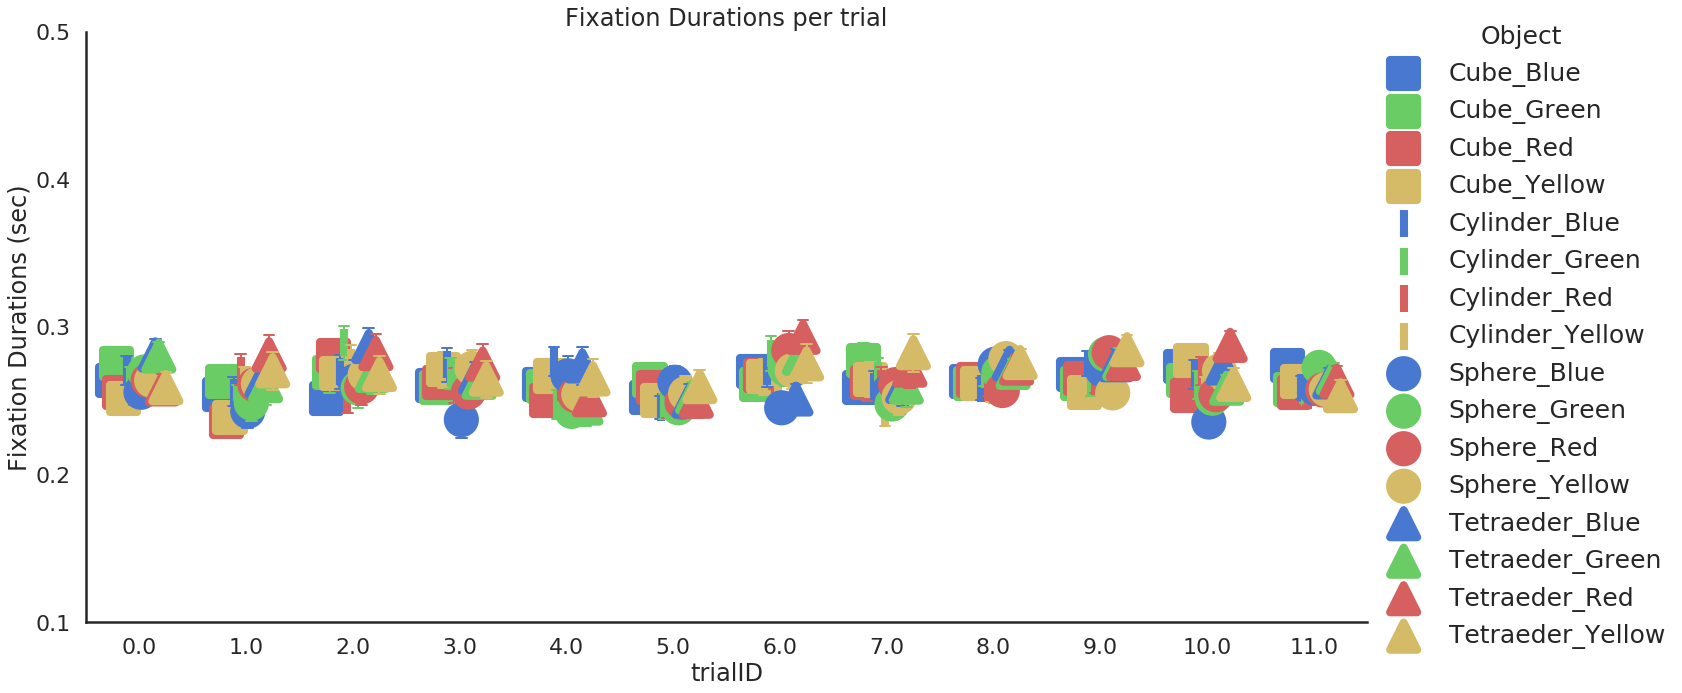

In [58]:
objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 'Cylinder_Blue', 'Cylinder_Green',
                  'Cylinder_Red','Cylinder_Yellow', 'Sphere_Blue', 'Sphere_Green', 'Sphere_Red',
                  'Sphere_Yellow', 'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']
markers = ['s','s','s','s', '|','|','|','|', 'o','o','o','o', '^','^','^','^']
colors = ['b', 'g', 'r', 'y']
tmpdf = (samples_df
 .drop_duplicates(subset=['fix_duration'], keep='first')
 .query('isFixV == 1 and corrected_fix_duration !=0 and combinedEye_raycastHitObject != "Other" and isOutlierFix==0')
 .groupby(['subjectID','trialID','subjectfileName','trialNum','combinedEye_raycastHitObject'], as_index=False)
 .corrected_fix_duration
 .mean()
 .rename(columns = {'corrected_fix_duration':'FixationDuration'})
)

# _, ax = plt.subplots(1,1,figsize=(12,9))
# sns.pointplot(data=tmpdf, x='trialID', y='NumSamples', hue='combinedEye_raycastHitObject',palette='deep',
#               errwidth=2, capsize=0.1, saturation=0.5, ci=68, join=False, dodge=True, legend_out=True)
sns.set(context = "poster", style="white", palette="muted", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':25, 'font.sans-serif':'DejaVu Sans'})
g = (
    sns.catplot(
        x='trialID', y='FixationDuration', data=tmpdf, hue ='combinedEye_raycastHitObject',
        hue_order=objs, markers=markers, palette=colors,
                  kind='point',scale = 2,
                  errwidth=2, capsize=0.1,
                  ci=68,  dodge=0.5, join=False,
        height = 10, aspect = 2, legend_out=False, legend=False
        
    )
)
g.set(ylabel='Fixation Durations (sec)', ylim=(0.1,0.5), yticks=[0.1, 0.2, 0.3, 0.4, 0.5])
plt.legend(title = 'Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.05), fontsize=25)
plt.title('Fixation Durations per trial')
plt.savefig(PLOT_PATH+'/fixdur_pertrial.png', transparent=True, bbox_inches='tight', quality=90)

Text(0.5, 1.0, 'Fixations & Grasped Object vs. Time (Subject-2063, Trial = 3)')

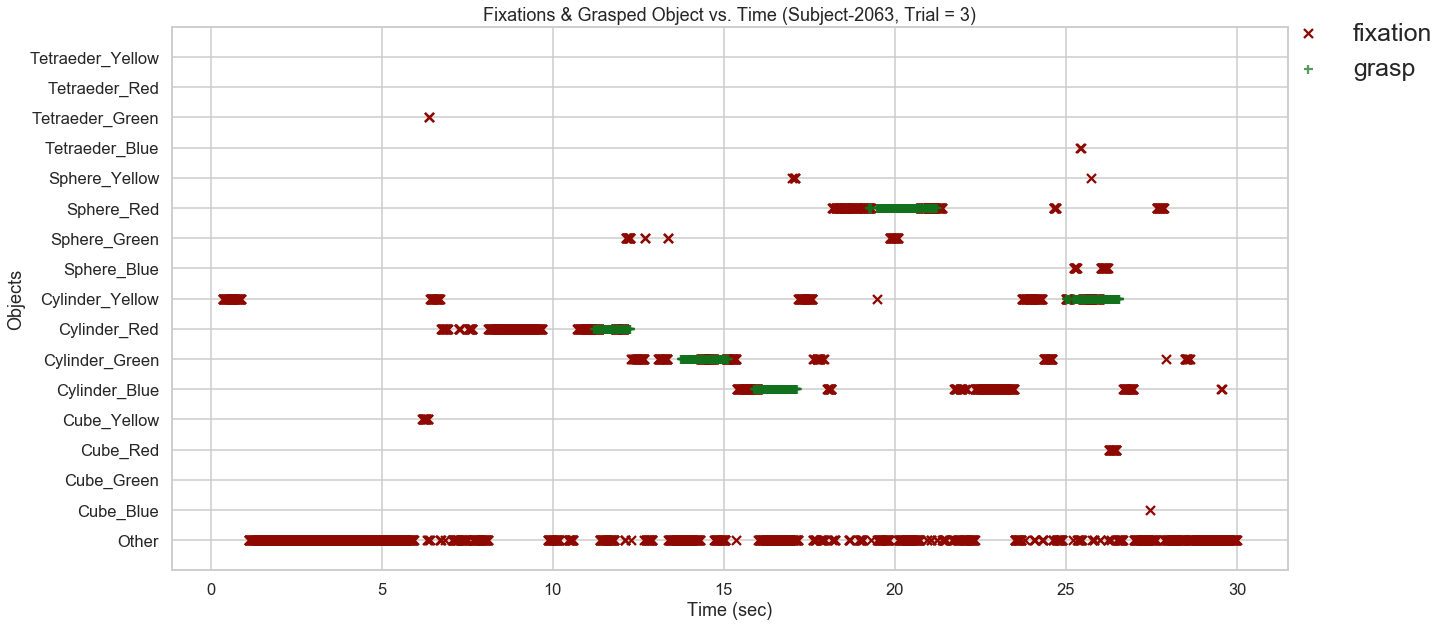

In [87]:
subject=2063
trial=3
tmpdf = (
    samples_df
    .rename(columns={'combinedEye_raycastHitObject':'eyeHit', 'handData_graspedObject':'grasp',\
                     'nosePointer_raycastHitObject':'head' })
    .query('subjectID == @subject & trialNum == @trial')
#     .query('eyeHit != "Other"')
    .query('timestamp<=30')
#     .sort_values('timestamp')
    [['timestamp', 'eyeHit', 'grasp']]
    .set_index('timestamp')
)
sns.set(context = "talk", style="whitegrid", palette="dark", font_scale=1, rc={'figure.figsize':(11.7,8.27)})
_, ax = plt.subplots(figsize=(20,10))
tmpdf['eyeHit'] = tmpdf['eyeHit'].map(objs_dict)
tmpdf['grasp'] = tmpdf['grasp'].map(objs_dict)
# tmpdf['head'] = tmpdf['head'].map(objs_dict)
ax.scatter(tmpdf.index, tmpdf['eyeHit'],color = 'r', alpha=1, label='fixation', marker='x')
ax.scatter(tmpdf.index, tmpdf['grasp'],color = 'g', alpha=0.7, label='grasp', marker='+')
# ax.scatter(tmpdf.index, tmpdf['head'],color = 'b', alpha=0.3, label='head', marker='o')

ax.set_yticks(np.arange(0, 17))
ax.set_ylim(-1,17)
ax.set_yticklabels([obj for obj in objs_dict.keys()])
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Objects')
ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.15, 1.05), fontsize=25)
ax.set_title(f'Fixations & Grasped Object vs. Time (Subject-{subject}, Trial = {trial})')
# plt.savefig(f'{PLOT_PATH}/eye_grasp_{subject}_{trial}.png', transparent=True, bbox_inches='tight', quality=90)



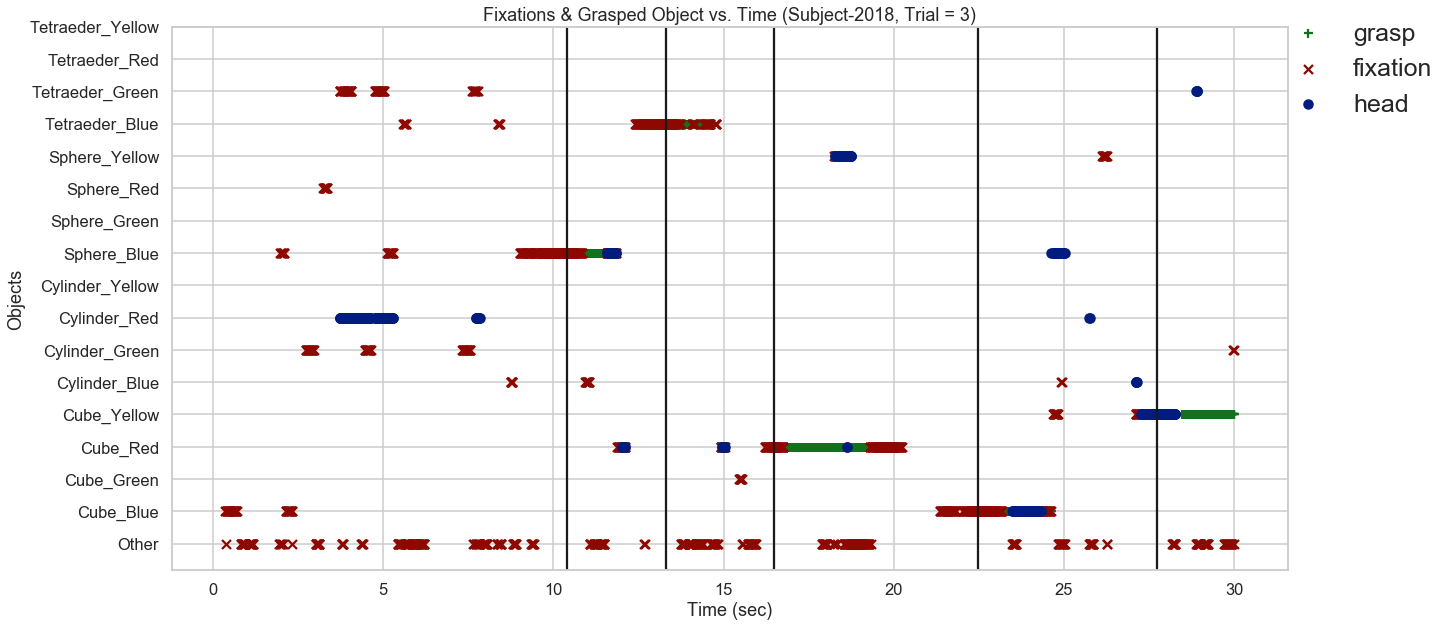

In [19]:
subject=2018
trial=3
tmpdf = (
    samples_df
    .rename(columns={'combinedEye_raycastHitObject':'eyeHit', 'handData_graspedObject':'grasp',\
                     'nosePointer_raycastHitObject':'head' })
    
    .query('subjectID == @subject & trialNum == @trial')
#     .query('eyeHit != "Other"')
    .query('timestamp<=30')
#     .sort_values('timestamp')
    [['timestamp', 'eyeHit', 'grasp', 'head', 'grasp_onset_bool', 'fix_onset_bool', 'isFixV', 'trialID']]
    .set_index('timestamp')
    
)
sns.set(context = "talk", style="whitegrid", palette="dark", font_scale=1, rc={'figure.figsize':(11.7,8.27)})
_, ax = plt.subplots(figsize=(20,10))
for i, val in tmpdf.iterrows():
#     print(val)
    if val.grasp_onset_bool == True:
        plt.axvline(i, color='k')

tmpdf['grasp'] = tmpdf['grasp'].map(objs_dict)
ax.scatter(tmpdf.index, tmpdf['grasp'],color = 'g', alpha=1, label='grasp', marker='+')

tmpdf = tmpdf.query('isFixV==1')
tmpdf['eyeHit'] = tmpdf['eyeHit'].map(objs_dict)
tmpdf['head'] = tmpdf['head'].map(objs_dict)
ax.scatter(tmpdf.index, tmpdf['eyeHit'],color = 'r', alpha=1, label='fixation', marker='x')
ax.scatter(tmpdf.index, tmpdf['head'],color = 'b', alpha=1, label='head', marker='o')

# tmpdf['eyeHit'].plot(ax=ax, label='eyeHits', yticks=np.arange(17),color = COLORS['r'], alpha=0.5)
# tmpdf['grasp'].plot(ax=ax, label='grasp', color = COLORS['g'], linestyle=':')

# for i, val in tmpdf.iterrows():
# #     print(val)
#     if val.grasp_onset_bool == True:
#         plt.axvline(i, color='k')
# #     if val.fix_onset_bool == True:
# #         plt.axvline(i, color='grey', ls=':')
        
ax.set_yticks(np.arange(0, 17))
# ax.set_xlim(12,35)
ax.set_yticklabels([obj for obj in objs_dict.keys()])
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Objects')
ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.15, 1.05), fontsize=25)
ax.set_title(f'Fixations & Grasped Object vs. Time (Subject-{subject}, Trial = {trial})')
plt.savefig(f'{PLOT_PATH}/head_eye_grasp_{subject}_{trial}.png', transparent=True, bbox_inches='tight', quality=90)

In [20]:
tmpdf.trialID

timestamp
0.360805     6.0
0.371895     6.0
0.383151     6.0
0.394054     6.0
0.405413     6.0
            ... 
29.920687    6.0
29.931808    6.0
29.976103    6.0
29.987247    6.0
29.998987    6.0
Name: trialID, Length: 1566, dtype: float64

# Scratch

In [15]:
samples_df['hand_theta_h'] = np.arctan2(samples_df['handData_transform_rotation_x'], samples_df['handData_transform_rotation_z'])
samples_df['hand_theta_v'] = np.arctan2(samples_df['handData_transform_rotation_y'], samples_df['handData_transform_rotation_z'])
samples_df['hand_angle'] =np.sqrt(samples_df.hand_theta_h**2 + samples_df.hand_theta_v**2)

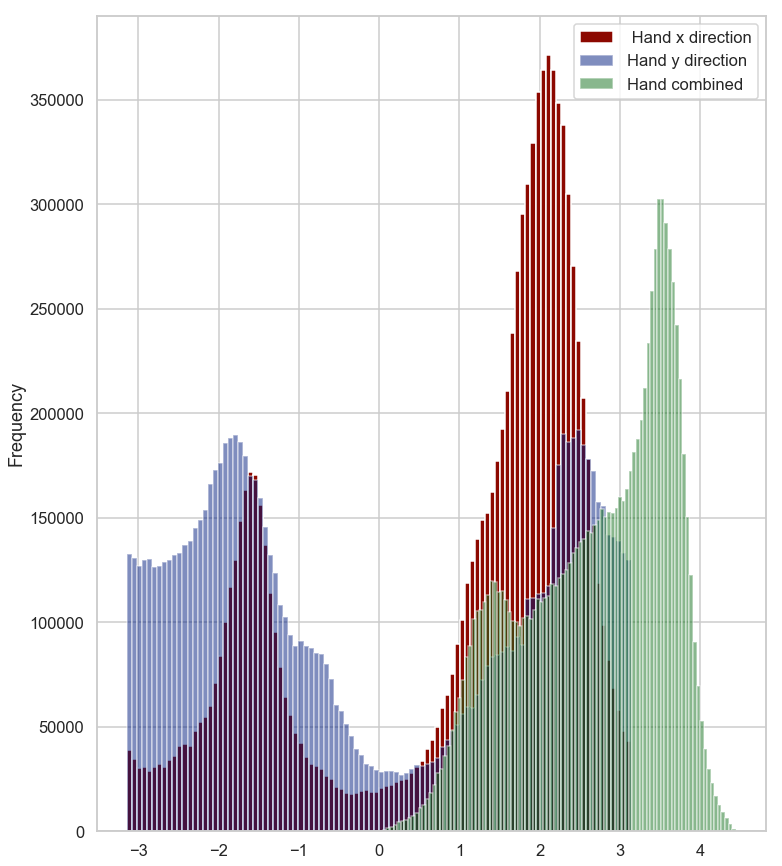

In [16]:
_, ax = plt.subplots(1,1,figsize=(12,15), sharey=True)

(samples_df
.hand_theta_h
.plot
.hist(bins=100, color='r', ax=ax, label=' Hand x direction', legend=True)
)
(samples_df
.hand_theta_v
.plot
.hist(bins=100, color='b', ax=ax, label='Hand y direction', legend=True, alpha=0.5)
)
(samples_df
.hand_angle
.plot
.hist(bins=100, color='g', ax=ax, label='Hand combined', legend=True, alpha=0.5)
)
# ax.set(xlim=(-5000, 5000), xlabel = 'Angular Acceleration in $^\circ$/sec$^2$')
# plt.savefig(f'{PLOT_PATH}/hand_theta_hist.png', transparent=True, bbox_inches='tight', quality=90)

In [17]:
samples_df['head_angle'] =np.sqrt(samples_df.head_theta_h**2 + samples_df.head_theta_v**2)
samples_df['eye_angle'] =np.sqrt(samples_df.combined_eye_theta_h**2 + samples_df.combined_eye_theta_v**2)

Text(0, 0.5, 'Horizontal Angular Displacement')

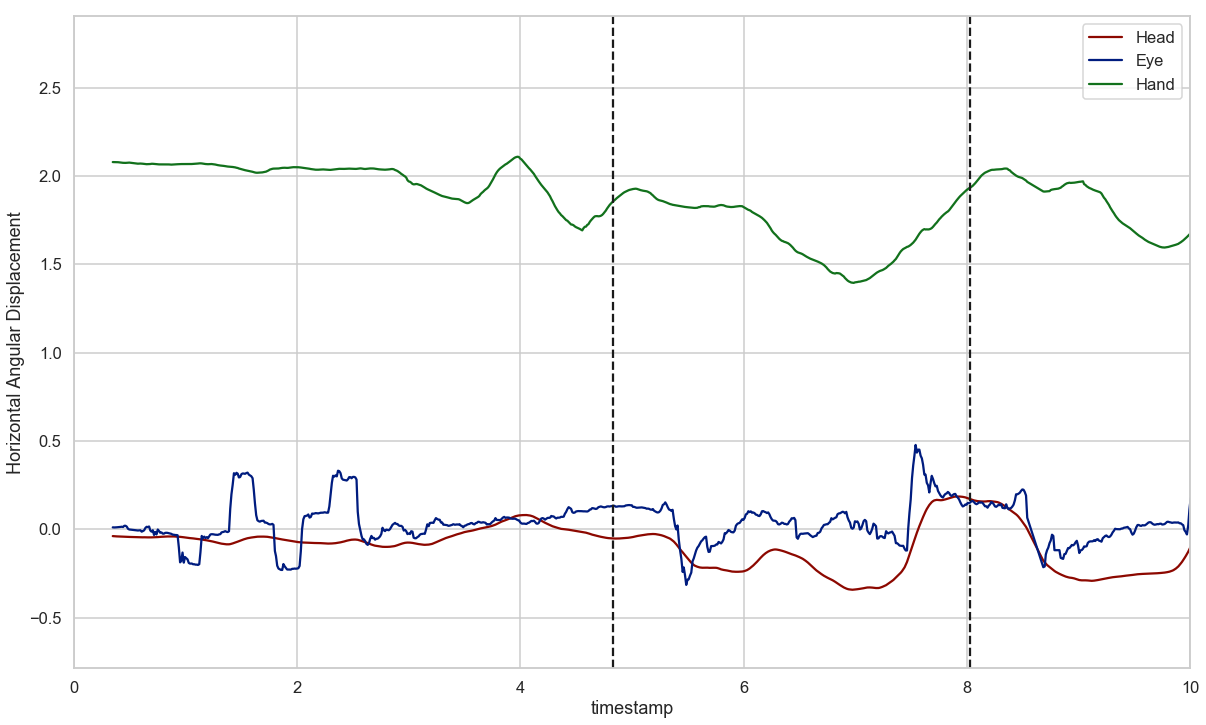

In [31]:
subject = 2018
trial = 6
_, ax = plt.subplots(figsize=(20, 12))

(samples_df
 .query('subjectID == @subject and trialNum==@trial')
 .plot('timestamp', 'head_theta_h', kind='line', ax=ax, label='Head', color='r', legend=True)
)
(samples_df
 .query('subjectID == @subject and trialNum==@trial')
 .plot('timestamp', 'combined_eye_theta_h', kind='line', ax=ax, label='Eye', color='b', legend=True)
)
(samples_df
 .query('subjectID == @subject and trialNum==@trial')
 .plot('timestamp', 'hand_theta_h', kind='line', ax=ax, label='Hand', color='g', legend=True)
)
tmpdf = samples_df.query('subjectID == @subject and trialNum==@trial')
for i, val in tmpdf.iterrows():
#     print(val)
    if val.grasp_onset_bool == True:
        plt.axvline(val.timestamp, color='k', ls='--')
ax.set_xlim(0, 10)
ax.set_ylabel('Horizontal Angular Displacement')

In [23]:
samples_df['hand_angular_vel'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .hand_angle
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))

Text(0, 0.5, 'Horizontal Angular Displacement')

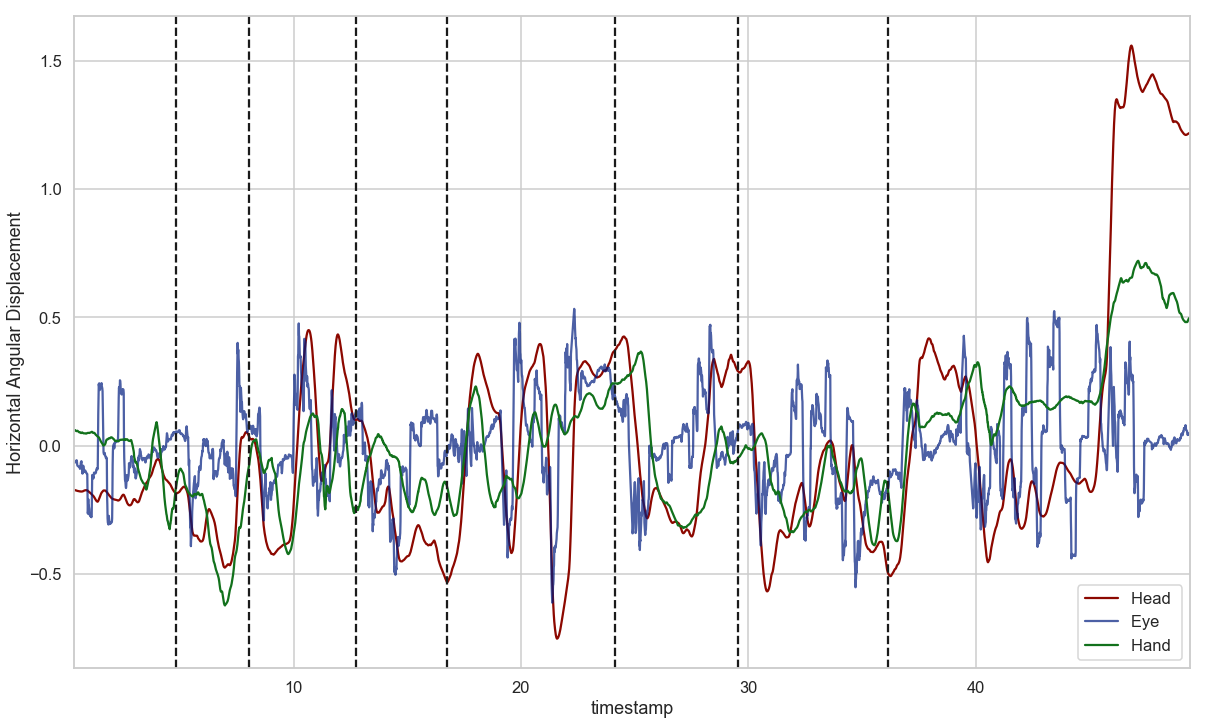

In [34]:
_, ax = plt.subplots(figsize=(20, 12))

subject = 2018
trial = 6
tmpdf = samples_df.query('subjectID == @subject and trialNum==@trial')
tmpdf.head_theta_h = tmpdf.head_theta_h - tmpdf.head_theta_h.mean()
tmpdf.combined_eye_theta_h = tmpdf.combined_eye_theta_h - tmpdf.combined_eye_theta_h.mean()
tmpdf.hand_theta_h = tmpdf.hand_theta_h - tmpdf.hand_theta_h.mean()
(tmpdf
 .plot('timestamp', 'head_theta_h', kind='line', ax=ax, label='Head ', color='r', legend=True)
)
(tmpdf
 .plot('timestamp', 'combined_eye_theta_h', kind='line', ax=ax, label='Eye  ', color='b', alpha=0.7, legend=True)
)
(tmpdf
 .plot('timestamp', 'hand_theta_h', kind='line', ax=ax, label='Hand ', color='g', legend=True)
)

for i, val in tmpdf.iterrows():
#     print(val)
    if val.grasp_onset_bool == True:
        plt.axvline(val.timestamp, color='k', ls='--')

# ax.set_xlim(0, 10)

ax.set_ylabel('Horizontal Angular Displacement')

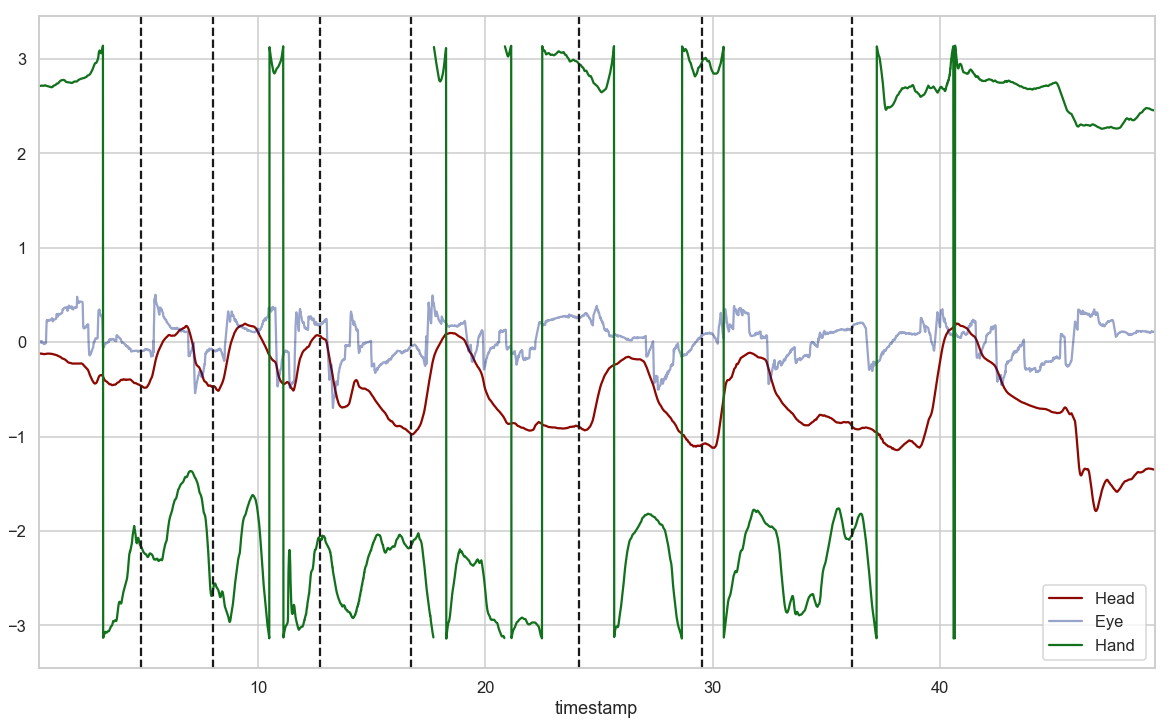

In [29]:
_, ax = plt.subplots(figsize=(20, 12))

subject = 2018
trial = 6
tmpdf = samples_df.query('subjectID == @subject and trialNum==@trial')
tmpdf.head_theta_h = tmpdf.head_theta_h - tmpdf.head_theta_h.mean()
tmpdf.combined_eye_theta_h = tmpdf.combined_eye_theta_h - tmpdf.combined_eye_theta_h.mean()
tmpdf.hand_theta_h = tmpdf.hand_theta_h - tmpdf.hand_theta_h.mean()
(tmpdf
 .plot('timestamp', 'head_theta_v', kind='line', ax=ax, label='Head ', color='r', legend=True)
)
(tmpdf
 .plot('timestamp', 'combined_eye_theta_v', kind='line', ax=ax, label='Eye  ', color='b', alpha=0.4, legend=True)
)
(tmpdf
 .plot('timestamp', 'hand_theta_v', kind='line', ax=ax, label='Hand ', color='g', legend=True)
)

for i, val in tmpdf.iterrows():
#     print(val)
    if val.grasp_onset_bool == True:
        plt.axvline(val.timestamp, color='k', ls='--')

# ax.set_xlim(0, 10)

# ax.set_xlabel('timestamp')

(0, 20)

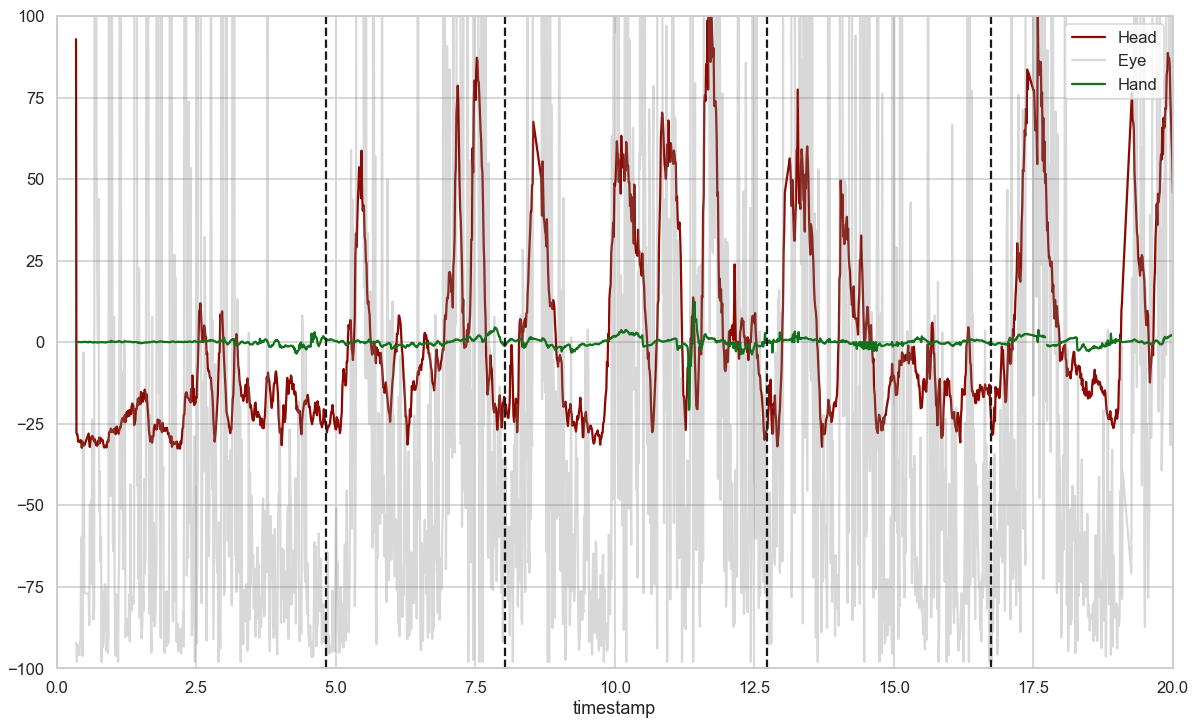

In [28]:
_, ax = plt.subplots(figsize=(20, 12))

subject = 2018
trial = 6
tmpdf = samples_df.query('subjectID == @subject and trialNum==@trial')
tmpdf.head_angular_vel = tmpdf.head_angular_vel - tmpdf.head_angular_vel.mean()
tmpdf.angular_vel = tmpdf.angular_vel - tmpdf.angular_vel.mean()
tmpdf.hand_angular_vel = tmpdf.hand_angular_vel - tmpdf.hand_angular_vel.mean()
(tmpdf
 .plot('timestamp', 'head_angular_vel', kind='line', ax=ax, label='Head', color='r', legend=True)
)
(tmpdf
 .plot('timestamp', 'angular_vel', kind='line', ax=ax, label='Eye ', color='grey',alpha=0.3, legend=True)
)
(tmpdf
 .plot('timestamp', 'hand_angular_vel', kind='line', ax=ax, label='Hand', color='g', legend=True)
)

for i, val in tmpdf.iterrows():
#     print(val)
    if val.grasp_onset_bool == True:
        plt.axvline(val.timestamp, color='k', ls='--')
ax.set_ylim(-100, 100)
ax.set_xlim(0, 20)
# ax.set_xlabel('timestamp')

In [ ]:
samples_df.isFixV.sum()

In [ ]:
samples_df.columns

In [ ]:
tmpdf.loc[tmpdf.NumFixation.idxmax(), :]

In [ ]:
samples_df.handData_graspedObject.unique()